In [35]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from dowhy import gcm
from tigramite import data_processing as pp
from tigramite.toymodels import structural_causal_processes as toys
from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests.parcorr import ParCorr
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose

# Article charts

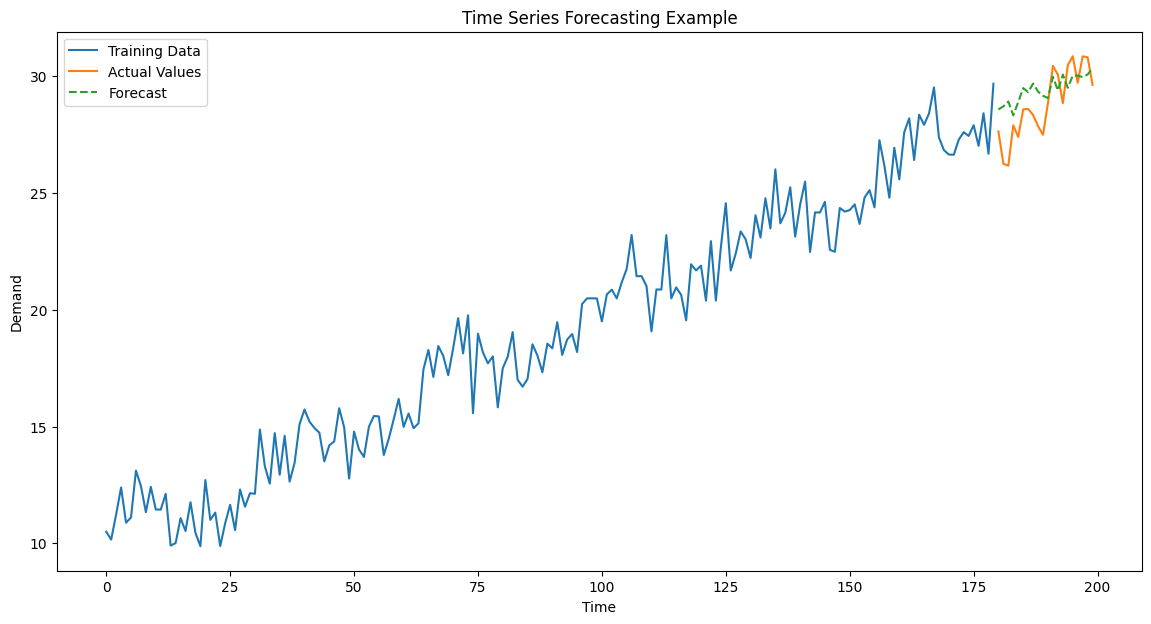

In [36]:
# Set the seed for reproducibility
np.random.seed(42)

# Generate a synthetic time series dataset
num_samples = 200
time = np.arange(num_samples)
seasonal_pattern = 10 + np.sin(time / 5)
trend = time * 0.1
noise = np.random.normal(scale=1.0, size=num_samples)
series = seasonal_pattern + trend + noise

# Create a DataFrame
df = pd.DataFrame({'Time': time, 'Demand': series})

# Split into train and test sets
train = df.iloc[:180]
test = df.iloc[180:]

# Fit an Exponential Smoothing model
model = ExponentialSmoothing(train['Demand'], trend='add', seasonal='add', seasonal_periods=20)
fit = model.fit()

# Forecast the next 20 periods
forecast = fit.forecast(20)

# Plot the original time series and the forecasted values
plt.figure(figsize=(14, 7))
sns.lineplot(x=train['Time'], y=train['Demand'], label='Training Data')
sns.lineplot(x=test['Time'], y=test['Demand'], label='Actual Values')
sns.lineplot(x=np.arange(180, 200), y=forecast, label='Forecast', linestyle='--')
plt.title('Time Series Forecasting Example')
plt.xlabel('Time')
plt.ylabel('Demand')
plt.legend()
plt.show()


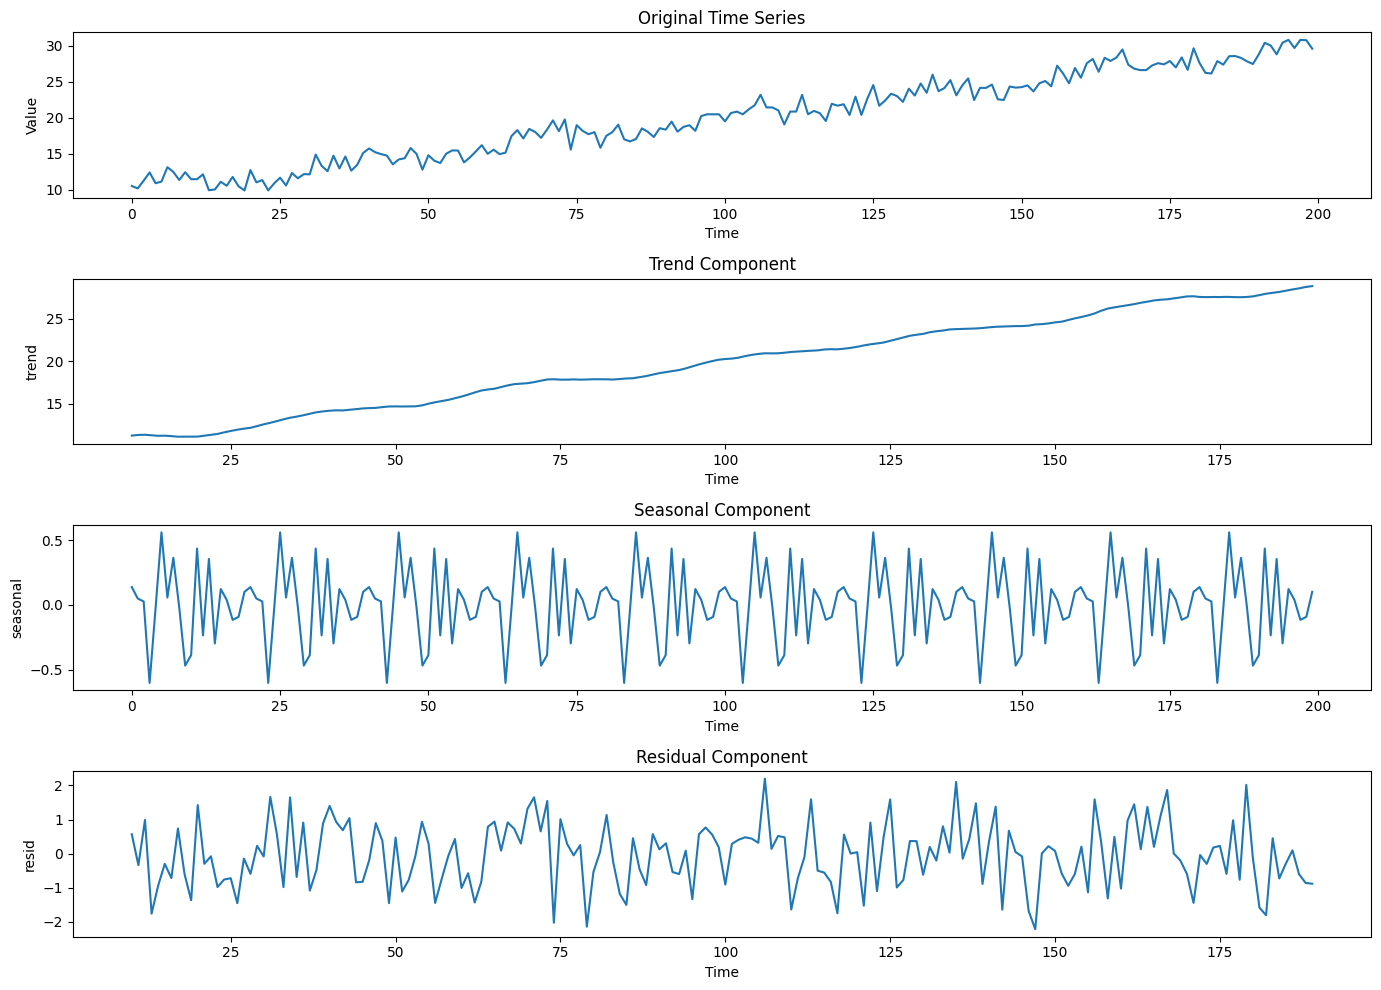

In [37]:
# Set the seed for reproducibility
np.random.seed(42)

# Generate a synthetic time series dataset
num_samples = 200
time = np.arange(num_samples)
seasonal_pattern = 10 + np.sin(time / 5)
trend = time * 0.1
noise = np.random.normal(scale=1.0, size=num_samples)
series = seasonal_pattern + trend + noise

# Create a DataFrame
df = pd.DataFrame({'Time': time, 'Value': series})

# Perform seasonal decomposition
result = seasonal_decompose(df['Value'], period=20, model='additive')

# Plot the decomposed components
plt.figure(figsize=(14, 10))

plt.subplot(4, 1, 1)
sns.lineplot(x=df['Time'], y=df['Value'])
plt.title('Original Time Series')

plt.subplot(4, 1, 2)
sns.lineplot(x=df['Time'], y=result.trend)
plt.title('Trend Component')

plt.subplot(4, 1, 3)
sns.lineplot(x=df['Time'], y=result.seasonal)
plt.title('Seasonal Component')

plt.subplot(4, 1, 4)
sns.lineplot(x=df['Time'], y=result.resid)
plt.title('Residual Component')

plt.tight_layout()
plt.show()


# Causal graph

In [38]:
# Create node lookup for channels
node_lookup = {0: 'ice cream sales',
               1: 'coastal visits',
               2: 'temperature',           
               3: 'shark attacks',
 }

total_nodes = len(node_lookup)

# Create adjacency matrix - this is the base for our graph
graph_actual = np.zeros((total_nodes, total_nodes))

# Create graph using expert domain knowledge
graph_actual[1, 0] = 1.0 # direct
graph_actual[2, 1] = 1.0 # indirect
graph_actual[2, 3] = 1.0 # spurious
     
graph_actual

array([[0., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 1.],
       [0., 0., 0., 0.]])

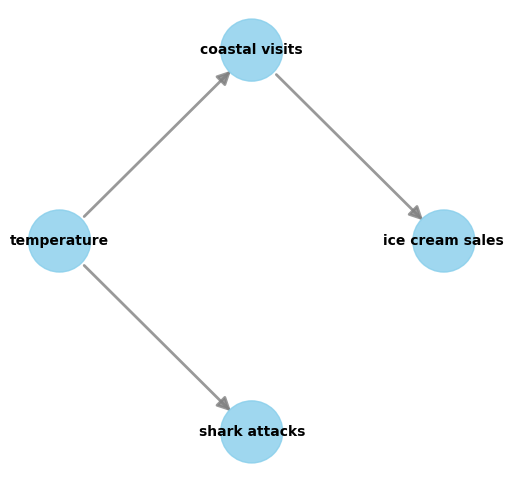

In [39]:
# Setup graph
graph = nx.from_numpy_array(graph_actual, create_using=nx.DiGraph)
graph = nx.relabel_nodes(graph, node_lookup)
gcm.util.plot(graph, figure_size=(6,6))

# Data generating process

\begin{align*}
X^3_t &= 0.2 X^3_{t-1} + 0.9 X^2_{t-1} + \eta^3_t\\
X^2_t &= 0.7 X^2_{t-1} + \eta^2_t\\
X^1_t &= 0.5 X^1_{t-1} + 1.2 X^2_{t-1} + \eta^1_t\\
X^0_t &= 0.2 X^0_{t-1} + 1.8 X^1_{t-1} + \eta^0_t\\
\end{align*}

In [40]:
seed=42
np.random.seed(seed)

# Data generating process
def lin_f(x): 
    return x

# x_num: (x_num, time_lag), weight, lin_f)

links_coeffs = {0: [((0, -1), 0.2, lin_f), ((1, -1), 0.9, lin_f)],
                1: [((1, -1), 0.5, lin_f), ((2, -1), 1.2, lin_f)],
                2: [((2, -1), 0.7, lin_f)],
                3: [((3, -1), 0.2, lin_f), ((2, -1), 1.8, lin_f) ],      
}

T = 1000 # time series length

data, _ = toys.structural_causal_process(links_coeffs, T=T, seed=seed)

T, N = data.shape

var_names = [node_lookup[i] for i in sorted(node_lookup.keys())]

# Initialize dataframe object, specify time axis and variable names
df = pp.DataFrame(data, 
                  datatime = {0:np.arange(len(data))}, 
                  var_names=var_names)

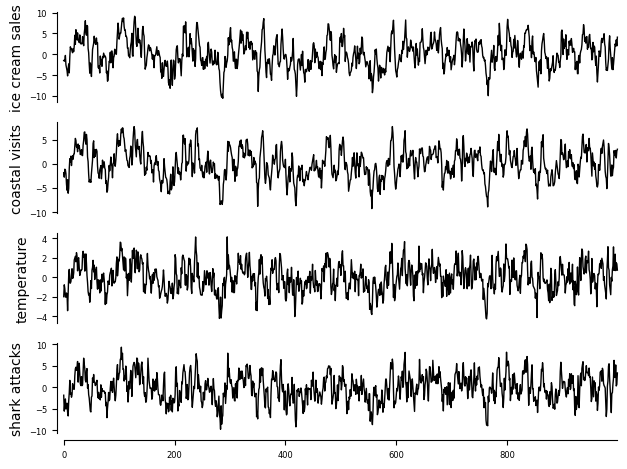

In [41]:
tp.plot_timeseries(df)
plt.show()

# Causal discovery

In [42]:
parcorr = ParCorr(significance='analytic')
pcmci = PCMCI(
    dataframe=df, 
    cond_ind_test=parcorr,
    verbosity=1)

In [43]:
pcmci.verbosity = 1
results = pcmci.run_pcmci(tau_max=2, pc_alpha=None, alpha_level=0.01)


##
## Step 1: PC1 algorithm for selecting lagged conditions
##

Parameters:
independence test = par_corr
tau_min = 1
tau_max = 2
pc_alpha = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
max_conds_dim = None
max_combinations = 1



## Resulting lagged parent (super)sets:

    Variable ice cream sales has 2 link(s):
    [pc_alpha = 0.05]
        (coastal visits -1): max_pval = 0.00000, |min_val| =  0.819
        (ice cream sales -1): max_pval = 0.00000, |min_val| =  0.197

    Variable coastal visits has 2 link(s):
    [pc_alpha = 0.05]
        (temperature -1): max_pval = 0.00000, |min_val| =  0.794
        (coastal visits -1): max_pval = 0.00000, |min_val| =  0.605

    Variable temperature has 2 link(s):
    [pc_alpha = 0.1]
        (temperature -1): max_pval = 0.00000, |min_val| =  0.556
        (shark attacks -1): max_pval = 0.09764, |min_val| =  0.053

    Variable shark attacks has 2 link(s):
    [pc_alpha = 0.05]
        (temperature -1): max_pval = 0.00000, |min_val| =  0.879
        (shark 

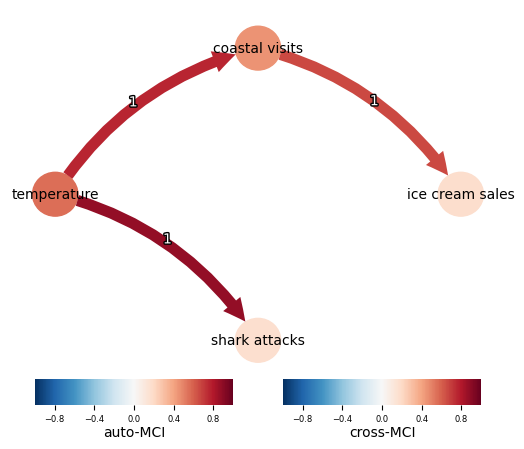

In [44]:
tp.plot_graph(
    val_matrix=results['val_matrix'],
    graph=results['graph'],
    var_names=var_names,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',
    show_autodependency_lags=False
    ) 

plt.show()

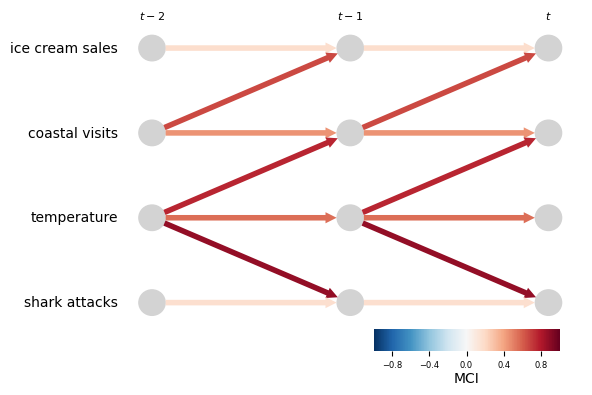

In [45]:
tp.plot_time_series_graph(
    figsize=(6, 4),
    val_matrix=results['val_matrix'],
    graph=results['graph'],
    var_names=var_names,
    link_colorbar_label='MCI',
    )

plt.show()

# Pre-processing

In [46]:
# create dataframne
df_pd = pd.DataFrame(df.values[0], columns=var_names)

# calcuate lagged values for each column
lag_periods = 1 

for col in var_names:
    df_pd[f'{col}_lag{lag_periods}'] = df_pd[col].shift(lag_periods)
    
# remove 1st obervations where we don't have lagged values
df_pd = df_pd.iloc[1:, :]

df_pd

,ice cream sales,coastal visits,temperature,shark attacks,ice cream sales_lag1,coastal visits_lag1,temperature_lag1,shark attacks_lag1
1,-1.384004,-2.754008,-0.767998,-5.534699,-1.518368,-1.823461,-1.982441,-1.830166
2,-1.672356,-1.112897,-1.172961,-3.706618,-1.384004,-2.754008,-0.767998,-5.534699
3,-0.282276,-1.245048,-2.010739,-2.693190,-1.672356,-1.112897,-1.172961,-3.706618
4,-2.554668,-2.039363,-2.031863,-5.050756,-0.282276,-1.245048,-2.010739,-2.693190
5,-3.284185,-4.214712,-1.606829,-4.153890,-2.554668,-2.039363,-2.031863,-5.050756
...,...,...,...,...,...,...,...,...
995,2.488253,1.708539,2.370500,2.356855,0.700723,2.119593,1.748656,2.366400
996,2.015697,2.777009,0.685971,5.224456,2.488253,1.708539,2.370500,2.356855
997,3.454938,1.207713,1.487313,0.330268,2.015697,2.777009,0.685971,5.224456
998,2.001843,2.595900,1.377264,0.692860,3.454938,1.207713,1.487313,0.330268


In [47]:
df_pd

,ice cream sales,coastal visits,temperature,shark attacks,ice cream sales_lag1,coastal visits_lag1,temperature_lag1,shark attacks_lag1
1,-1.384004,-2.754008,-0.767998,-5.534699,-1.518368,-1.823461,-1.982441,-1.830166
2,-1.672356,-1.112897,-1.172961,-3.706618,-1.384004,-2.754008,-0.767998,-5.534699
3,-0.282276,-1.245048,-2.010739,-2.693190,-1.672356,-1.112897,-1.172961,-3.706618
4,-2.554668,-2.039363,-2.031863,-5.050756,-0.282276,-1.245048,-2.010739,-2.693190
5,-3.284185,-4.214712,-1.606829,-4.153890,-2.554668,-2.039363,-2.031863,-5.050756
...,...,...,...,...,...,...,...,...
995,2.488253,1.708539,2.370500,2.356855,0.700723,2.119593,1.748656,2.366400
996,2.015697,2.777009,0.685971,5.224456,2.488253,1.708539,2.370500,2.356855
997,3.454938,1.207713,1.487313,0.330268,2.015697,2.777009,0.685971,5.224456
998,2.001843,2.595900,1.377264,0.692860,3.454938,1.207713,1.487313,0.330268


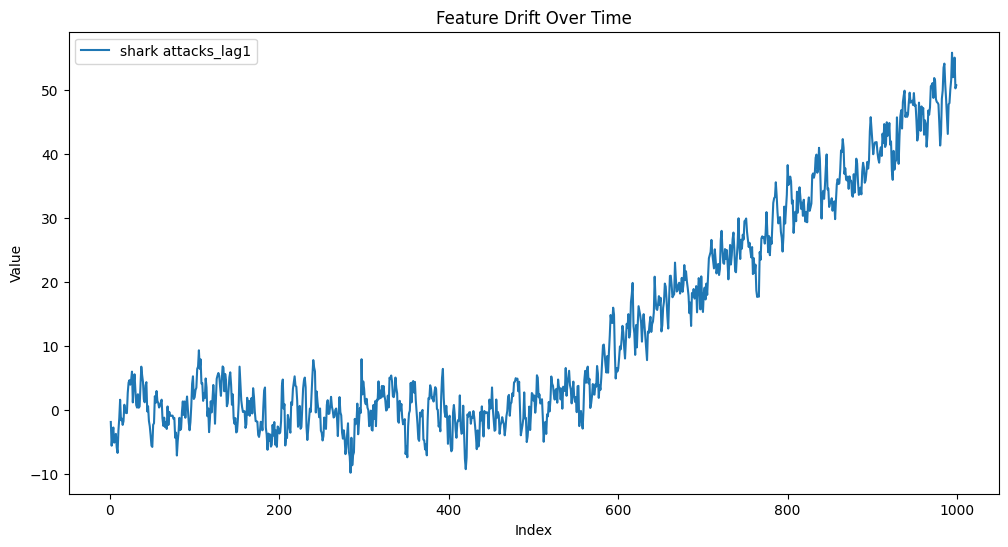

In [48]:
# function to introduce feature drift based on indexes
def introduce_feature_drift(df, start_idx, end_idx, drift_amount):
    drift_period = (df.index >= start_idx) & (df.index <= end_idx)
    df.loc[drift_period, 'shark attacks_lag1'] += np.linspace(0, drift_amount, drift_period.sum())
    return df
    
# introduce feature drift
df_pd = introduce_feature_drift(df_pd, start_idx=500, end_idx=999, drift_amount=50.0)

# visualise drift
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_pd[['shark attacks_lag1']])
plt.title('Feature Drift Over Time')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend(['shark attacks_lag1'])
plt.show()

# Model training

In [53]:
# use first 500 observations for training
df_train = df_pd.iloc[0:500, :]

# use last 100 observations for evaluation
df_test = df_pd.iloc[900:, :]

# set feature lists
X_causal_cols = ["ice cream sales_lag1", "coastal visits_lag1"]
X_spurious_cols = ["ice cream sales_lag1", "coastal visits_lag1", "temperature_lag1", "shark attacks_lag1"]

# create target, train and test sets
y_train = df_train['ice cream sales'].copy()
y_test = df_test['ice cream sales'].copy()
X_causal_train = df_train[X_causal_cols].copy()
X_causal_test = df_test[X_causal_cols].copy()
X_spurious_train = df_train[X_spurious_cols].copy()
X_spurious_test = df_test[X_spurious_cols].copy()

In [54]:
# train and validate model
model_causal = RidgeCV()
model_causal = model_causal.fit(X_causal_train, y_train)
print(f'Coefficient: {model_causal.coef_}')

yhat_causal_train = model_causal.predict(X_causal_train)
yhat_causal_test = model_causal.predict(X_causal_test)

mse_train = mean_squared_error(y_train, yhat_causal_train)
mse_test = mean_squared_error(y_test, yhat_causal_test)
print(f"Mean Squared Error train: {round(mse_train, 2)}")
print(f"Mean Squared Error test: {round(mse_test, 2)}")

r2_train = r2_score(y_train, yhat_causal_train)
r2_test = r2_score(y_test, yhat_causal_test)
print(f"R2 train: {round(r2_train, 2)}")
print(f"R2 test: {round(r2_test, 2)}")

Coefficient: [0.18129423 0.9076422 ]
Mean Squared Error train: 1.01
Mean Squared Error test: 1.22
R2 train: 0.92
R2 test: 0.84


In [55]:
# train and validate model
model_spurious = RidgeCV()
model_spurious = model_spurious.fit(X_spurious_train, y_train)
print(f'Coefficient: {model_spurious.coef_}')

yhat_spurious_train = model_spurious.predict(X_spurious_train)
yhat_spurious_test = model_spurious.predict(X_spurious_test)

mse_train = mean_squared_error(y_train, yhat_spurious_train)
mse_test = mean_squared_error(y_test, yhat_spurious_test)
print(f"Mean Squared Error train: {round(mse_train, 2)}")
print(f"Mean Squared Error test: {round(mse_test, 2)}")

r2_train = r2_score(y_train, yhat_spurious_train)
r2_test = r2_score(y_test, yhat_spurious_test)
print(f"R2 train: {round(r2_train, 2)}")
print(f"R2 test: {round(r2_test, 2)}") 

Coefficient: [ 0.17759139  0.9461939   0.02262042 -0.04736462]
Mean Squared Error train: 1.0
Mean Squared Error test: 6.23
R2 train: 0.92
R2 test: 0.19


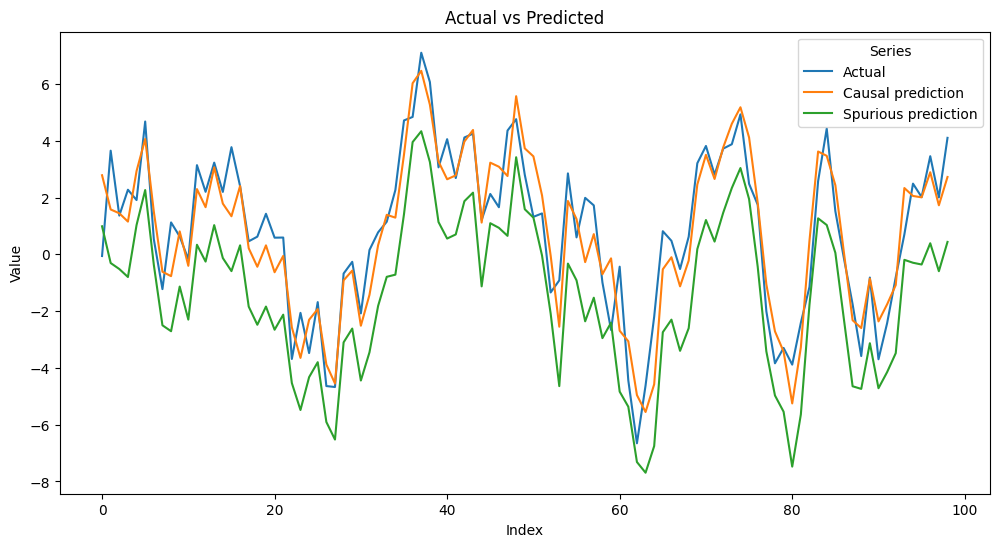

In [56]:
# combine results
df_comp = pd.DataFrame({
    'Index': np.arange(99),
    'Actual': y_test,
    'Causal prediction': yhat_causal_test,
    'Spurious prediction': yhat_spurious_test
})

# melt the DataFrame to long format for seaborn
df_melted = df_comp.melt(id_vars=['Index'], value_vars=['Actual', 'Causal prediction', 'Spurious prediction'], var_name='Series', value_name='Value')

# visualise results for test set
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_melted, x='Index', y='Value', hue='Series')
plt.title('Actual vs Predicted')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend(title='Series')
plt.show()